In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split

In [4]:
members = pd.read_csv("/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/members.csv", delimiter=",")
sample_submission = pd.read_csv("/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/sample_submission.csv")
extra = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/song_extra_info.csv')
songs = pd.read_csv("/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/songs.csv")
test = pd.read_csv("/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/test.csv")
train = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train.csv')

train_target = train["target"]
train.drop(["target"], axis=1, inplace=True)
train_target.to_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train_target.csv', index=False)

test.drop(["id"], axis=1, inplace=True)

In [5]:
songs = songs.merge(extra, on='song_id', how='left', suffixes=('', '_extra'))

## Генерация признаков

Заметим, что в датасете songs есть фича isrc - проведя минуту в гугле, я узнал, что это международный индивидуальный код для звукозаписей, который можно воспринимать как идентификатор. Так, в нём (на 5 и 6 позиции) содерждится и год создания звукозаписи.

In [6]:
def year_generating(isrc):
    if str(isrc) == isrc:
        if int(isrc[5:7]) <= 17:
            return 2000 + int(isrc[5:7])
        else:
            return 1900 + int(isrc[5:7])
    else:
        return "NaN"

In [7]:
songs['song_year'] = songs['isrc'].apply(year_generating)

train = train.merge(songs, on = 'song_id', how = 'left')
test = test.merge(songs, on = 'song_id', how = 'left')

train.drop(["isrc"], axis=1, inplace=True)
test.drop(["isrc"], axis=1, inplace=True)

Посчитаем, сколько раз каждая песня прослушивалась, и добавим соответствующий признак num_of_times_played в train и test

In [8]:
dict_count_song_played_train = {idd: times for idd, times in train['song_id'].value_counts().iteritems()}
dict_count_song_played_test = {idd: times for idd, times in test['song_id'].value_counts().iteritems()}

def num_played(x):
    try:
        return dict_count_song_played_train[x]
    except KeyError:
        try:
            return dict_count_song_played_test[x]
        except KeyError:
            return 0
        
train['num_played'] = train['song_id'].apply(lambda x: num_played(x))
test['num_played'] = test['song_id'].apply(lambda x: num_played(x))

Теперь рассмотрим активность каждого юзера по отдельности - в train и test выборках за индентификацию юзеров отвечает "msno"

In [9]:
dict_user_activity = {idd :times for idd,times in pd.concat([train['msno'] , test['msno']] , axis = 0).value_counts().iteritems()}

def return_user_activity(x):
    try:
        return dict_user_activity[x]
    except KeyError:
        return 0
    
train['user_activity_msno'] = train['msno'].apply(lambda x: return_user_activity(x))
test['user_activity_msno'] = test['msno'].apply(lambda x: return_user_activity(x))

Даты регистрации и экспирации даны нам в строковом формате без разделяющих знаков - сгенерируем на их основе несколько дополнительных признаков, касающихся дня, месяца и года соответствующих событий. Они будут полезны для EDA и аналитики касательно активности пользоваталей в зависимости от времени регистрации.

In [10]:
members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[:4]))
members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[:4]))
members["registration_month"] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members["expiration_month"] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members["registration_day"] = members['registration_init_time'].apply(lambda x: int(str(x)[6:]))
members["expiration_day"] = members['expiration_date'].apply(lambda x: int(str(x)[6:]))

Сгенерируем ещё один признак на основе этих дат - длительность пользования сервисом.

In [11]:
def add_subscription_duration(users_data):
    members['registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
    members['expiration_date'] = pd.to_datetime(members['expiration_date'], format='%Y%m%d')
    users_data['duration'] = (users_data['expiration_date'] - users_data['registration_init_time']).dt.days

add_subscription_duration(members)

В members содержится несколько полезных дополнительных признаков, касающихся юзеров - смёрджим их с трейном и тестом по юзерайди

In [12]:
members.drop(["registration_init_time", "expiration_date"], axis=1, inplace=True)
train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

Признак фита (совместной песни) также будет уместен для рекомендации пользователю. Рекомендации было бы полезно выстроить и с опорой на то, что человек, любящий творчество артиста A, нередко оценит и его совместную композицию с артистом B, однако для построения такой базовой логики в модели потребуются огромные вычислительные мощности, связанные с генерацией множества бинарных признаков.

In [13]:
def is_featured(x):
    if 'feat' in str(x) :
        return 1
    else:  
        return 0

train['is_featured'] = train['artist_name'].apply(is_featured)
test['is_featured'] = test['artist_name'].apply(is_featured)

Из длительности песни так же можно сгенерировать некоторые признаки - например, сравни длину каждой песни со средней по датасету, создав бинарный признак на этой основе.

In [14]:
def smaller_song(x):
    if x < avg_song_length:
        return 1
    else:
        return 0

avg_song_length = np.mean(train['song_length'])

train['smaller_song'] = train['song_length'].apply(smaller_song)
test['smaller_song'] = test['song_length'].apply(smaller_song)

train["song_length"] = train["song_length"] / 1000
test["song_length"] = test["song_length"] / 1000

Полезно будет и иметь представление о популярности артиста - так, если он имеет много прослушиваний, то его можно смело рекомендовать новым пользователям.

In [15]:
count_artist_played_train = {idd: times for idd, times in train['artist_name'].value_counts().iteritems()}
count_artist_played_test = {idd: times for idd, times in test['artist_name'].value_counts().iteritems()}

def count_artist_played(x):
    try:
        return count_artist_played_train[x]
    except KeyError:
        try:
            return count_artist_played_test[x]
        except KeyError:
            return 0
        
train['count_artist_played'] = train['artist_name'].apply(count_artist_played)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played)

Добавим признак для трека по количеству жанров, которым он принадлежит. Аналогично сделаем с количеством композиторов и исполнителей:

In [16]:
def genre_id_count(x):
    if pd.isnull(x):
        return 0
    else:
        return x.count('|') + 1
    
def composer_count(x):
    if pd.isnull(x):
        return 0
    else:
        x_str = str(x) 
        return sum(map(x_str.count, ['|', '/', '\\', ';'])) + 1

train['composer_count'] = train['composer'].apply(composer_count)
test['composer_count'] = test['composer'].apply(composer_count)

train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count)


Немного изучив датасет можно понять, что 52.0 - код английского языка. Сделаем бинарный признак, показывающий, на английском ли языке песня.

In [17]:
def language_song(x):
    if '17.0' in str(x) or '52.0' in str(x):
        return 1
    return 0

train['is_52'] = train['language'].apply(language_song)
test['is_52'] = test['language'].apply(language_song)


Попробуем сгруппировать слушателей по косвенным признакам - активности, месту, возрасту, времени нахождения на сервисе. Сгенерируем на основе принадлежности к той или иной группе кластер-признак. Предварительно стандартизуем данные для работы k-средних.

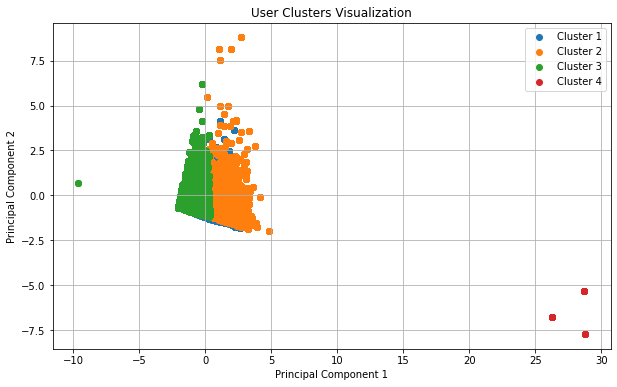

In [18]:
user_features = train[['user_activity_msno', 'city', 'bd', 'duration']]

scaler = StandardScaler()
scaled_user_features = scaler.fit_transform(user_features)

kmeans = KMeans(n_clusters=4, random_state=42)
train['user_cluster'] = kmeans.fit_predict(scaled_user_features) + 1
test_scaled_user_features = scaler.transform(test[['user_activity_msno', 'city', 'bd', 'duration']])
test['user_cluster'] = kmeans.predict(test_scaled_user_features) + 1

pca = PCA(n_components=2)
user_features_pca = pca.fit_transform(scaled_user_features)

cluster_labels = kmeans.labels_

plt.figure(figsize=(10, 6))
for cluster in range(4):
    plt.scatter(user_features_pca[cluster_labels == cluster, 0], 
                user_features_pca[cluster_labels == cluster, 1], 
                label=f'Cluster {cluster + 1}')

plt.title('User Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

## Сохраняем результаты обработки датасета

In [19]:
train.to_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train_after_gen.csv', index=False)
test.to_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/test_after_gen.csv', index=False)